In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import numpy as np
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [98]:
methods = ["Postgres", "Postgres2D",  "NeuroCard", "BayesCard", "PessemisticCardinality", "SafeBound"]
benchmarks = ['JOBLight','JOBLightRanges', "JOBM", "Stats"]
runs = list(range(1,6))
inferenceResults = {method : {benchmark : dict() for benchmark in benchmarks} for method in methods}
rootFileDirectory = "/home/ec2-user/FrequencyBounds/Data/Results/"
for method in methods:
    for benchmark in benchmarks:
        for run in runs:
            querySize = pd.read_csv(rootFileDirectory + benchmark+"_Sizes.csv")
            resultFile = None
            if method == 'SafeBound':
                resultFile = rootFileDirectory + method + "_Inference_" + str(run) + "_" + benchmark + ".csv"
                if benchmark in []:
                    resultData = pd.DataFrame()
                    inferenceResults[method][benchmark][run] = resultData
                    continue
            elif method == 'SafeBoundScan':
                resultFile = rootFileDirectory + method + "_Inference_" +  str(run) + "_" + benchmark + ".csv"
                if benchmark in ["JOBLightRanges"]:
                    resultData = pd.DataFrame()
                    inferenceResults[method][benchmark][run] = resultData
                    continue
            elif method == 'Postgres' or method == "Postgres2D":
                resultFile = rootFileDirectory + method + "_Inference_" +  str(run) + "_" + benchmark + ".csv"
                if benchmark in [""]:
                    resultData = pd.DataFrame()
                    inferenceResults[method][benchmark][run] = resultData
                    continue
            elif method == 'BayesCard':
                resultFile = rootFileDirectory + method + "_Inference_" + benchmark + ".csv"
                if benchmark in ["JOBLightRanges", "JOBM"]:
                    resultData = pd.DataFrame()
                    inferenceResults[method][benchmark][run] = resultData
                    continue
            elif method == 'PessemisticCardinality':
                resultFile = rootFileDirectory + method + "_Inference_" + benchmark + ".csv"
                if benchmark in [""]:
                    resultData = pd.DataFrame()
                    inferenceResults[method][benchmark][run] = resultData
                    continue
            elif method == 'NeuroCard':
                resultFile = rootFileDirectory + method + "_Inference_" + benchmark + ".csv"
                if benchmark in ["Stats"]:
                    resultData = pd.DataFrame()
                    inferenceResults[method][benchmark][run] = resultData
                    continue
            
            resultData = pd.read_csv(resultFile)
            resultData = resultData.merge(querySize, on='QueryLabel')
            resultData["JoinSize"] = resultData["JoinSize"].astype(float)
            resultData["Estimate"] =  resultData["Estimate"].astype(float)
            resultData["RelativeError"] = resultData["Estimate"]/resultData["JoinSize"]
            resultData["QError"] = np.maximum(resultData["RelativeError"], 1./resultData["RelativeError"])
            resultData["Benchmark"] = benchmark
            resultData["Method"] = method
            resultData["Run"] = run
            inferenceResults[method][benchmark][run] = resultData
            

In [99]:
allData = pd.concat([inferenceResults[method][benchmark][run] for method in methods for benchmark in benchmarks for run in runs])

In [100]:
p05Error = allData.groupby(['Method', 'Benchmark', 'Run']).quantile(.05)
p50Error = allData.groupby(['Method', 'Benchmark', 'Run']).quantile(.50)
p95Error = allData.groupby(['Method', 'Benchmark', 'Run']).quantile(.95)
topLineData = p05Error.join(p50Error["RelativeError"], lsuffix="p05",rsuffix="p50").join(p95Error["RelativeError"])
topLineData["RelativeErrorp95"] = topLineData["RelativeError"]
topLineData = topLineData.reset_index()

In [101]:
topLineData[((topLineData["Method"]=="SafeBound") & (topLineData["Run"]==4)) | ((topLineData["Method"]=="Postgres")& (topLineData["Run"]==2))| ((topLineData["Method"]=="Postgres2D")& (topLineData["Run"]==2))| ((~topLineData["Method"].isin(["Postgres", "SafeBound", "Postgres2D"])))].groupby(["Method", "Benchmark"]).mean()[['RelativeErrorp05','RelativeErrorp50','RelativeErrorp95']]

RelativeErrorp05  RelativeErrorp50  \
Method                 Benchmark                                            
BayesCard              JOBLight                0.269774          1.001832   
                       Stats                   0.148015          0.827293   
NeuroCard              JOBLight                0.256539          0.795068   
                       JOBLightRanges          0.015624          0.700949   
                       JOBM                    0.003453          0.333613   
PessemisticCardinality JOBLight                2.873601         16.646252   
                       JOBLightRanges          1.331667         25.066667   
                       JOBM                   25.374013      10295.569595   
                       Stats                   1.043217         43.810061   
Postgres               JOBLight                0.001261          0.106706   
                       JOBLightRanges          0.000422          0.078522   
                       JOBM                    0.000101          0.006181   
                       Stats                   0.019375          1.131612   
Postgres2D             JOBLight                0.001588          0.115199   
                       JOBLightRanges          0.000364          0.076923   
                       JOBM                    0.000097          0.006059   
                       Stats                   0.019547          1.307724   
SafeBound              JOBLight                2.262353         12.106917   
                       JOBLightRanges          3.522844         91.242853   
                       JOBM                    5.697954        611.575416   
                       Stats                   1.312401         45.721613   

                                       RelativeErrorp95  
Method                 Benchmark                         
BayesCard              JOBLight            6.674691e+00  
                       Stats               1.031433e+01  
NeuroCard              JOBLight            2.050000e+00  
                       JOBLightRanges      1.615702e+00  
                       JOBM                2.700392e+00  
PessemisticCardinality JOBLight            1.525293e+02  
                       JOBLightRanges      5.765016e+02  
                       JOBM                1.977142e+06  
                       Stats               6.976458e+04  
Postgres               JOBLight            9.849187e-01  
                       JOBLightRanges      2.601413e+00  
                       JOBM                1.486394e+01  
                       Stats               6.593120e+02  
Postgres2D             JOBLight            1.661650e+00  
                       JOBLightRanges      2.639187e+00  
                       JOBM                1.438465e+01  
                       Stats               6.462958e+02  
SafeBound              JOBLight            1.040461e+03  
                       JOBLightRanges      1.305138e+04  
                       JOBM                1.800718e+06  
                       Stats               6.026319e+03

In [102]:
runData[(runData["Method"]=="SafeBound")&(runData["Run"]==4)].groupby('Benchmark')["RelativeError"].median()

Benchmark
JOBLight           12.106917
JOBLightRanges     91.242853
JOBM              611.575416
Stats              45.721613
Name: RelativeError, dtype: float64

In [103]:
runData[(runData["Method"]=="PessemisticCardinality")].groupby('Benchmark')["RelativeError"].median()

Benchmark
JOBLight             16.646252
JOBLightRanges       25.066667
JOBM              10295.569595
Stats                43.810061
Name: RelativeError, dtype: float64

/tmp/ipykernel_91607/1640285409.py:38: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if np.all(l.get_xdata() == [xmin, xmax]):


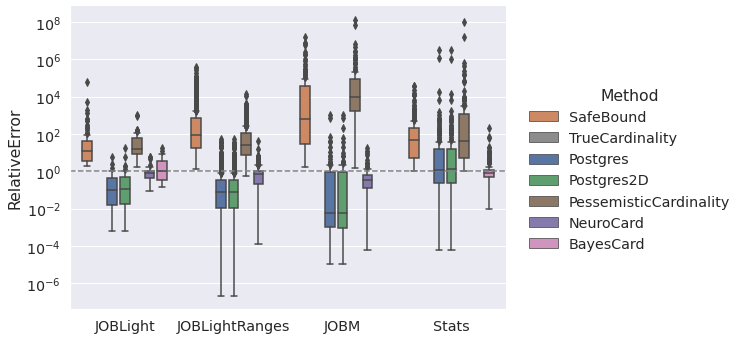

In [122]:
hueOrder =['SafeBound', "TrueCardinality",'Postgres', 'Postgres2D', 'PessemisticCardinality', "NeuroCard", 'BayesCard']
palette = ["C1", "C7", "C0", "C2", "C5", "C4", "C6"]
sn.set(font_scale = 1.3)
runData = allData[((allData["Method"]=='SafeBound')&(allData["Run"]==4))|((~allData["Method"].isin(['SafeBound']))&(allData["Run"]==2))]
inferencePlot = sn.catplot(x='Benchmark', y='RelativeError', hue='Method', kind='box', data=runData, height=5, aspect = 6/4, width=.8,palette=palette, hue_order=hueOrder)
inferencePlot.set(yscale='log', xlabel="")
inferencePlot.map(plt.axhline, y=1, ls='--', c='grey')
adjust_box_widths(inferencePlot.figure, 0.8)

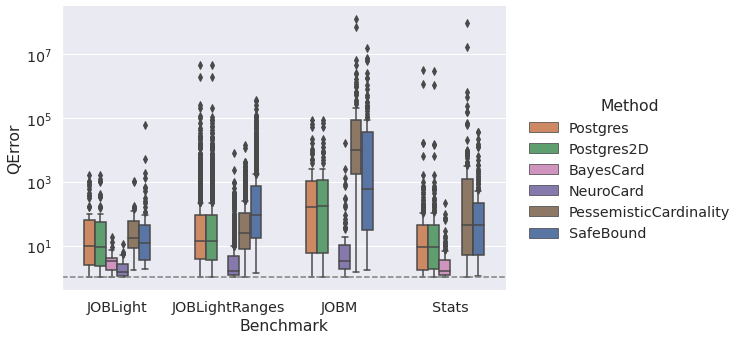

In [110]:
sn.set(font_scale = 1.3)
runData = allData[((allData["Method"]=='SafeBound')&(allData["Run"]==4))|((~allData["Method"].isin(['SafeBound']))&(allData["Run"]==2))]
inferencePlot = sn.catplot(x='Benchmark', y='QError', hue='Method', kind='box', data=runData, height=5, aspect = 6/4, width=.6,palette=["C1", "C2", "C6", "C4", "C5", "C0"],  hue_order=["Postgres", "Postgres2D", "BayesCard", 'NeuroCard', 'PessemisticCardinality', 'SafeBound'])
inferencePlot.set(yscale='log')
inferencePlot.map(plt.axhline, y=1, ls='--', c='grey')

In [109]:
runData.groupby(["Method", "Benchmark"]).max()

Unnamed: 0_x  QueryLabel  \
Method                 Benchmark                                  
BayesCard              JOBLight                  69          69   
                       Stats                    145         145   
NeuroCard              JOBLight                  69          69   
                       JOBLightRanges           999         999   
                       JOBM                     112         112   
PessemisticCardinality JOBLight                  69          69   
                       JOBLightRanges           999         999   
                       JOBM                     112         112   
                       Stats                    145         145   
Postgres               JOBLight                  69          69   
                       JOBLightRanges           999         999   
                       JOBM                     112         112   
                       Stats                    145         145   
Postgres2D             JOBLight                  69          69   
                       JOBLightRanges           999         999   
                       JOBM                     112         112   
                       Stats                    145         145   
SafeBound              JOBLight                  69          69   
                       JOBLightRanges           999         999   
                       JOBM                     112         112   
                       Stats                    145         145   

                                       InferenceTime      Estimate  StatsSize  \
Method                 Benchmark                                                
BayesCard              JOBLight             0.010032  4.530669e+09  1627311.0   
                       Stats                0.028202  4.786017e+11  6320277.0   
NeuroCard              JOBLight             0.523580  8.768241e+09        NaN   
                       JOBLightRanges       2.389435  2.273139e+11        NaN   
                       JOBM                 1.717933  1.304748e+07        NaN   
PessemisticCardinality JOBLight            17.403208  2.139135e+11       -1.0   
                       JOBLightRanges      17.974654  5.341567e+12       -1.0   
                       JOBM                18.937099  1.957083e+12       -1.0   
                       Stats                0.640932  1.709184e+14       -1.0   
Postgres               JOBLight             0.001326  3.707194e+07   204800.0   
                       JOBLightRanges       0.001454  8.977731e+08   270336.0   
                       JOBM                 0.030716  1.166224e+08   409600.0   
                       Stats                0.003114  1.406514e+11   303104.0   
Postgres2D             JOBLight             0.001745  3.579559e+07   229376.0   
                       JOBLightRanges       0.001486  9.416544e+08   335872.0   
                       JOBM                 0.030959  1.051453e+08   483328.0   
                       Stats                0.002221  1.422950e+11   376832.0   
SafeBound              JOBLight             0.002133  2.016423e+11   574610.0   
                       JOBLightRanges       0.003462  3.784013e+12   986272.0   
                       JOBM                 0.343239  2.332436e+10  6853838.0   
                       Stats                0.004250  1.231012e+13  2160940.0   

                                       Unnamed: 0_y      JoinSize  \
Method                 Benchmark                                    
BayesCard              JOBLight                  69  9.537311e+09   
                       Stats                    145  1.784923e+10   
NeuroCard              JOBLight                  69  9.537311e+09   
                       JOBLightRanges           999  2.336578e+11   
                       JOBM                     112  5.013649e+07   
PessemisticCardinality JOBLight                  69  9.537311e+09   
                       JOBLightRanges           999  2.336578e+11   
            

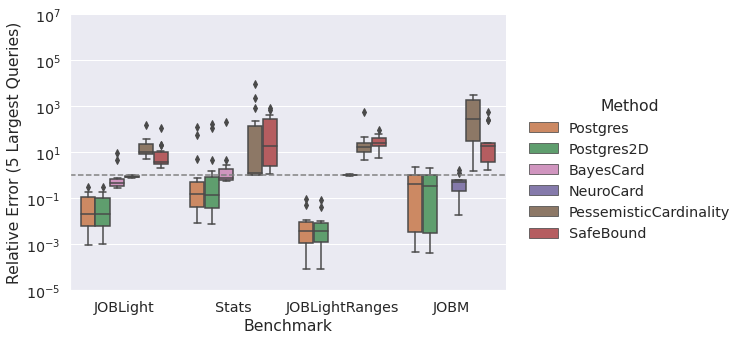

In [114]:
largestRunData = runData.groupby(["Method", "Benchmark"]).apply(lambda x: x.nlargest(15, 'JoinSize'))
inferencePlot = sn.catplot(x='Benchmark', y='RelativeError', hue='Method', kind='box', data=largestRunData, height=5, aspect = 6/4,palette=["C1", "C2", "C6", "C4", "C5", "C3"],  hue_order=["Postgres", "Postgres2D", "BayesCard", 'NeuroCard', 'PessemisticCardinality', 'SafeBound'], legend=True)
inferencePlot.set(ylabel="Relative Error (5 Largest Queries)", yscale='log', ylim=[.00001,10000000])
inferencePlot.map(plt.axhline, y=1, ls='--', c='grey')

In [23]:
largestRunData

,Method,Benchmark,level_2,JoinSize
0,BayesCard,JOBLight,21,9.537311e+09
1,BayesCard,JOBLight,18,1.352810e+09
2,BayesCard,JOBLight,20,6.253028e+08
3,BayesCard,JOBLight,17,5.125758e+08
4,BayesCard,JOBLight,59,4.929439e+08
...,...,...,...,...
175,SafeBound,Stats,5440,1.112747e+09
176,SafeBound,Stats,5358,5.931693e+08
177,SafeBound,Stats,5359,5.931693e+08
178,SafeBound,Stats,5364,5.373523e+08


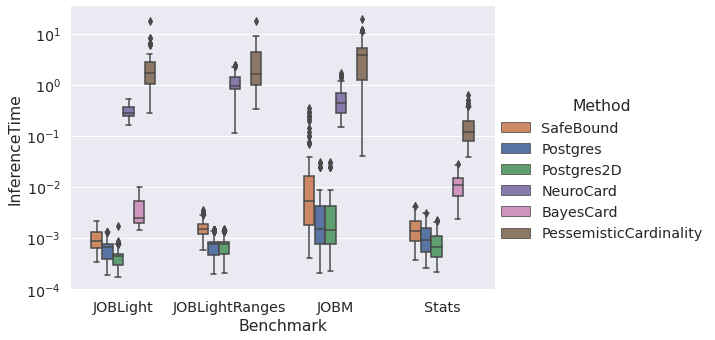

In [116]:
hueOrder =['SafeBound', 'Postgres', 'Postgres2D', "NeuroCard", 'BayesCard', 'PessemisticCardinality']
palette = ["C1", "C0","C2","C4", "C6", "C5"]
sn.set(font_scale = 1.3)
runData = allData[((allData["Method"]=='SafeBound')&(allData["Run"]==4))|((~allData["Method"].isin(["SafeBound"]))&(allData["Run"]==2))]
inferenceTimePlot = sn.catplot(x='Benchmark', y='InferenceTime', hue='Method', kind='box', data=runData, height=5, aspect = 6/4, width=.6, palette=palette, hue_order=hueOrder)
inferenceTimePlot.set(yscale='log')

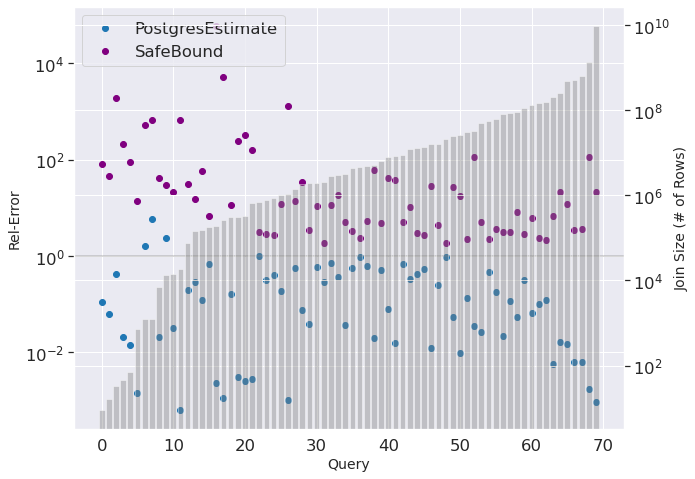

In [93]:
postgresData = runData[(runData["Method"] == "Postgres")&(runData["Benchmark"]=="JOBLight")].sort_values("JoinSize")
safeBoundData = runData[(runData["Method"] == "SafeBound")&(runData["Benchmark"]=="JOBLight")].sort_values("JoinSize")

fig, ax1 = plt.subplots(figsize=(10,7))
x_pos = np.arange(len(postgresData))
ax1.set_xlabel('Query', fontsize=14)
ax1.set_ylabel('Rel-Error', fontsize=14)
ax1.plot(x_pos, postgresData["RelativeError"], 'o', label = "PostgresEstimate", color="tab:blue")
ax1.plot(x_pos, safeBoundData["RelativeError"], 'o', label = "SafeBound", color="purple")
ax1.axhline(1, 0, 10, alpha=.4, color="grey")
ax1.set_yscale('log')
plt.legend(loc="upper left")
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Join Size (# of Rows)', fontsize=14)  # we already handled the x-label with ax1
ax2.bar(x_pos, postgresData["JoinSize"],  label = "Join Size", color="grey", alpha = 0.4)
ax2.set_yscale('log')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()